# **Лабораторна робота №13**
## Обробка зображень

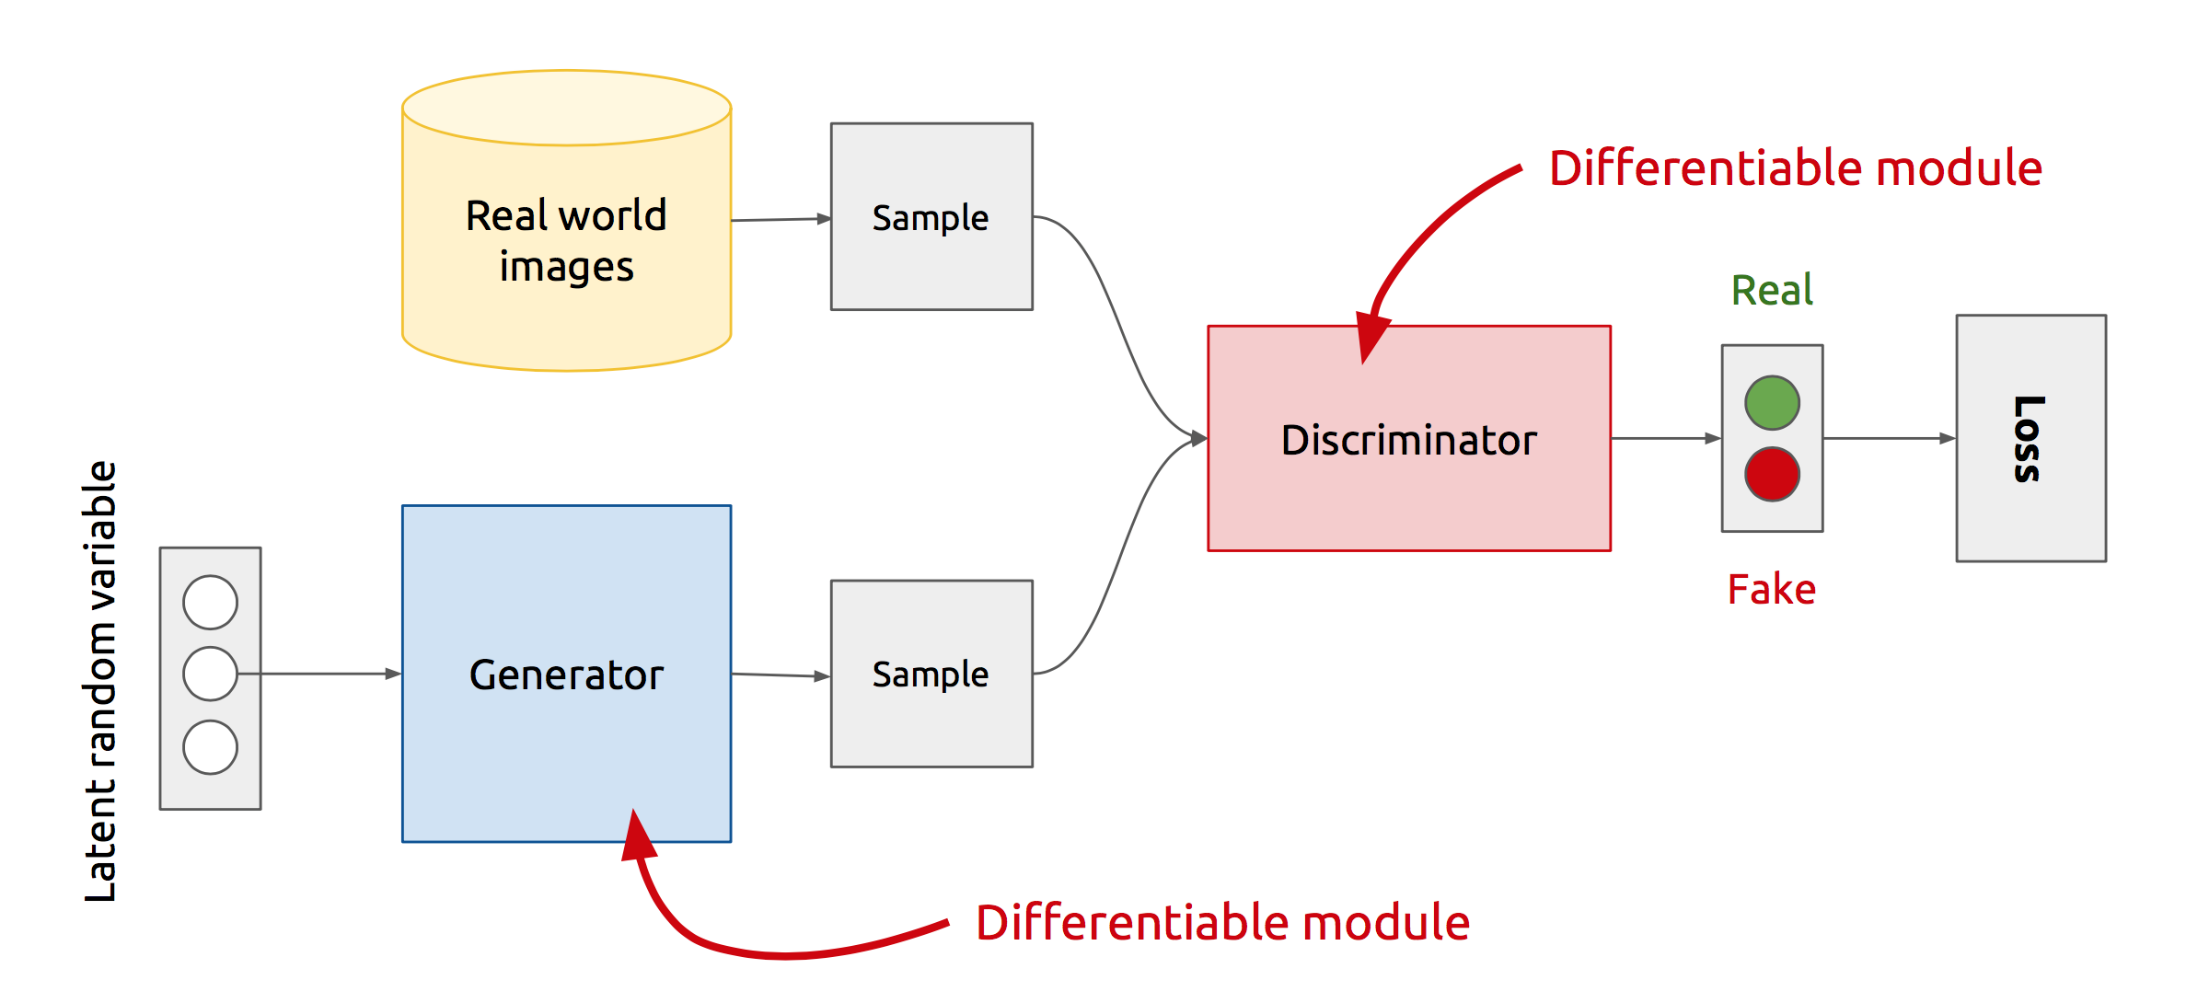

Генератор: створює підроблені зразки, намагається обдурити Дискримінатор

Дискримінатор: намагається відрізнити справжні зразки від підроблених

Вони тренуються один проти одного

Повторення багато разів призводить до отримання кращого генератора і дискримінатора

*   Z - це якийсь випадковий шум (Гауссівський/Рівномірний)
*   Z - можна розглядати як латентну репрезентацію образу.


# Generative Adversarial Network

In [1]:
!pip install protobuf~=3.2.3
!pip install tensorflow==2.12.0rc0

ERROR: Could not find a version that satisfies the requirement protobuf~=3.2.3 (from versions: 2.0.0b0, 2.0.3, 2.3.0, 2.4.1, 2.5.0, 2.6.0, 2.6.1, 3.0.0a2, 3.0.0a3, 3.0.0b1, 3.0.0b1.post1, 3.0.0b1.post2, 3.0.0b2, 3.0.0b2.post1, 3.0.0b2.post2, 3.0.0b3, 3.0.0b4, 3.0.0, 3.1.0, 3.1.0.post1, 3.2.0rc1, 3.2.0rc1.post1, 3.2.0rc2, 3.2.0, 3.3.0, 3.4.0, 3.5.0.post1, 3.5.1, 3.5.2, 3.5.2.post1, 3.6.0, 3.6.1, 3.7.0rc2, 3.7.0rc3, 3.7.0, 3.7.1, 3.8.0rc1, 3.8.0, 3.9.0rc1, 3.9.0, 3.9.1, 3.9.2, 3.10.0rc1, 3.10.0, 3.11.0rc1, 3.11.0rc2, 3.11.0, 3.11.1, 3.11.2, 3.11.3, 3.12.2, 3.12.4, 3.13.0rc3, 3.13.0, 3.14.0rc1, 3.14.0rc2, 3.14.0rc3, 3.14.0, 3.15.0rc1, 3.15.0rc2, 3.15.0, 3.15.1, 3.15.2, 3.15.3, 3.15.4, 3.15.5, 3.15.6, 3.15.7, 3.15.8, 3.16.0rc1, 3.16.0rc2, 3.16.0, 3.17.0rc1, 3.17.0rc2, 3.17.0, 3.17.1, 3.17.2, 3.17.3, 3.18.0rc1, 3.18.0rc2, 3.18.0, 3.18.1, 3.18.3, 3.19.0rc1, 3.19.0rc2, 3.19.0, 3.19.1, 3.19.2, 3.19.3, 3.19.4, 3.19.5, 3.19.6, 3.20.0rc1, 3.20.0rc2, 3.20.0, 3.20.1rc1, 3.20.1, 3.20.2, 3.20.3, 4.0.

In [2]:
# following https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py
# with minor modifications

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape[0], 'train samples')
print('image shape', x_train[0].shape)

60000 train samples
image shape (28, 28)


In [4]:
input_dim = 784
x_train = x_train.reshape(60000, input_dim)
print('input shape: ', x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]

input shape:  784


## Build Model

In [5]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)

In [6]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [7]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [8]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

In [9]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

## Train Model

In [10]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

             # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

4/4 [==============================] - 0s 7ms/step
epoch:  0
1/1 [==============================] - 0s 82ms/step


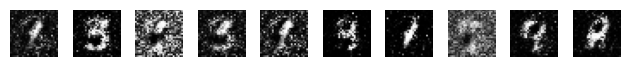

Выходные данные были обрезаны до нескольких последних строк (5000).
4/4 [==============================] - 0s 10ms/step
epoch:  20
1/1 [==============================] - 0s 28ms/step


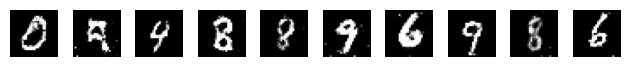

Выходные данные были обрезаны до нескольких последних строк (5000).
4/4 [==============================] - 0s 11ms/step
epoch:  40
1/1 [==============================] - 0s 27ms/step


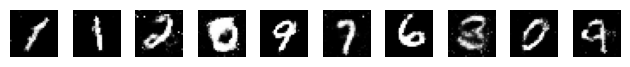

Выходные данные были обрезаны до нескольких последних строк (5000).
4/4 [==============================] - 0s 8ms/step
epoch:  60
1/1 [==============================] - 0s 27ms/step


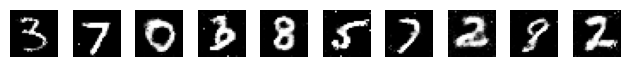

Выходные данные были обрезаны до нескольких последних строк (5000).
4/4 [==============================] - 0s 9ms/step
epoch:  80
1/1 [==============================] - 0s 26ms/step


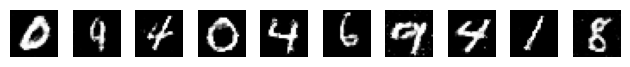

Выходные данные были обрезаны до нескольких последних строк (5000).
4/4 [==============================] - 0s 9ms/step
epoch:  100
1/1 [==============================] - 0s 30ms/step


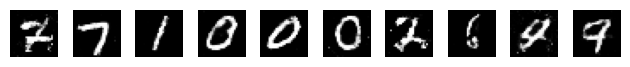

In [11]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)

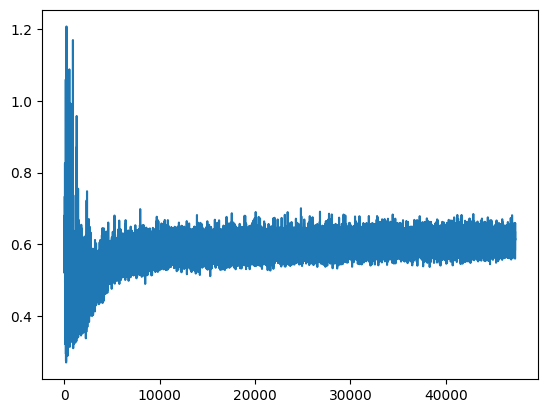

In [12]:
plt.plot(discrim_losses)

# Deep Convolutional GAN (DCGAN), 2015

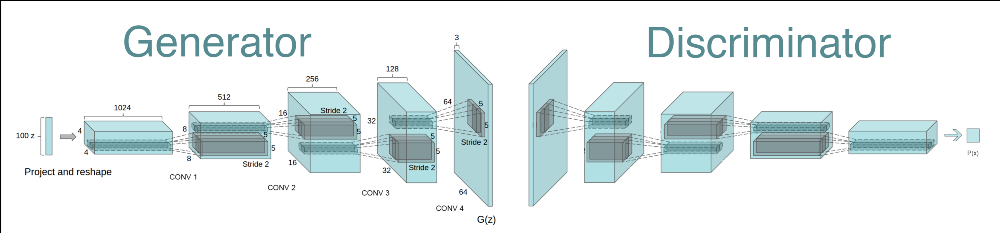

# Conv GAN

In [1]:
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
# with minor modifications
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Flatten, Reshape

from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [2]:
num_classes = 10
(x_train, _), (_, _) = cifar10.load_data()
print(x_train.shape)

(50000, 32, 32, 3)


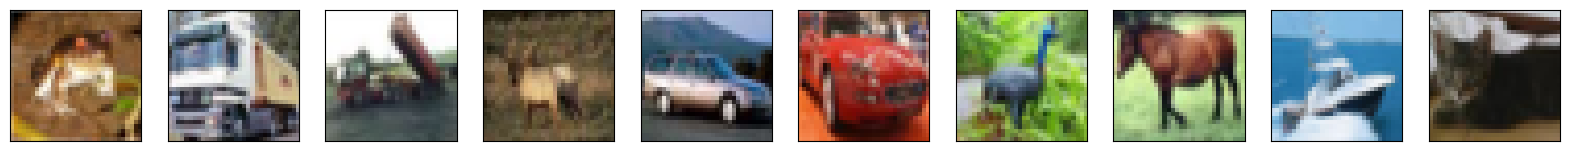

In [3]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [4]:
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalization [-1, 1]
x_train = np.clip(x_train, -1, 1)

## Build Model

In [ ]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [5]:
def build_discriminator():
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

In [6]:
latent_dim = 100

def build_generator():
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [7]:
def build_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [8]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    # scale from [-1,1] to [0,1]
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [9]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

             # Generate fake CIFAR images
            generated_images = generator.predict(noise)

            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss, _ = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 10 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

In [10]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)


epochs = 50 # to get good quality images, you should train the model for more than 100 epochs
batch_size = 128
train_model(epochs, batch_size)

NameError: name 'optim' is not defined

In [ ]:
plt.plot(discrim_losses)

# Variational Autoencoder (VAE)

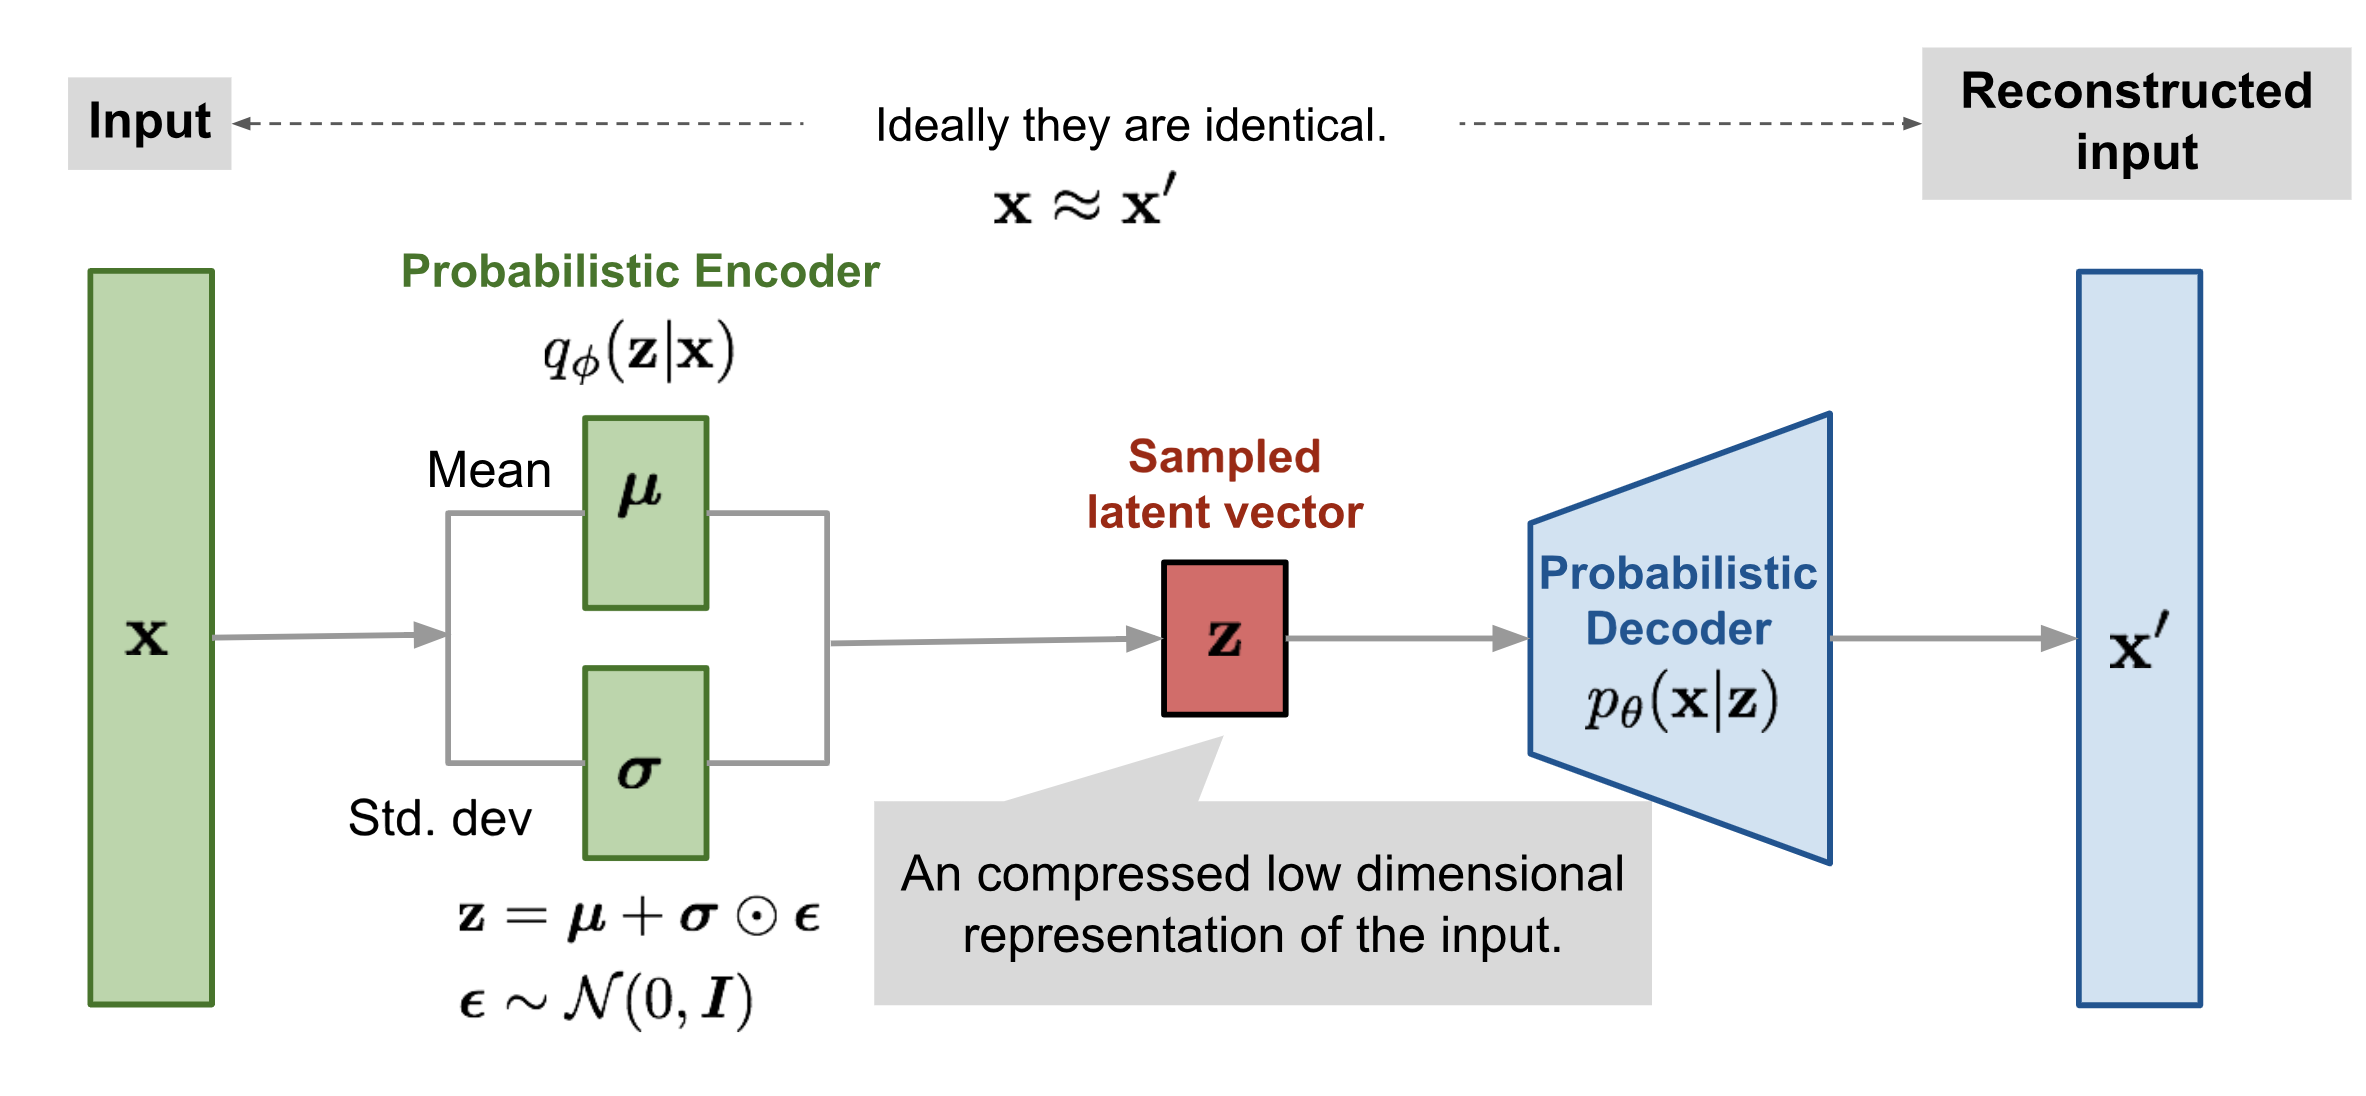

# Variational Autoencoder

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [12]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('image shape', x_train[0].shape)

60000 train samples
10000 test samples
image shape (28, 28)


In [13]:
original_dim = 28 * 28 #784

x_train = x_train.reshape(60000, original_dim)
x_test = x_test.reshape(10000, original_dim)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [14]:
# reparameterization trick
# z = z_mean + sqrt(var) * epsilon, epsilon = N(0,I)
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
def build_encoder():
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return

In [16]:
#Plot labels and MNIST digits as a function of the 2D latent vector

def plot_results(encoder, decoder, x_test, y_test, batch_size=128):

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()


In [17]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [18]:
# VAE model = encoder + decoder
# build encoder model
inputs = keras.Input(shape=input_shape, name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

In [19]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [22]:
# instantiate encoder model
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense_1[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense_1[0][0]']                
                                                                                            

In [21]:
# build decoder model
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)


In [23]:
# instantiate decoder model
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 512)               1536      
                                                                 
 dense_3 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [24]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs)

In [25]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          403972      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          403728      ['encoder[0][2]']                
                                                                                              

In [26]:
vae.fit(x_train,  epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/50
469/469 [==============================] - 17s 33ms/step - loss: 196.4346 - val_loss: 171.2111
Epoch 2/50
469/469 [==============================] - 17s 36ms/step - loss: 169.0983 - val_loss: 167.4152
Epoch 3/50
469/469 [==============================] - 16s 34ms/step - loss: 165.9016 - val_loss: 165.4218
Epoch 4/50
469/469 [==============================] - 15s 33ms/step - loss: 163.9420 - val_loss: 163.6559
Epoch 5/50
469/469 [==============================] - 15s 33ms/step - loss: 162.4504 - val_loss: 162.3732
Epoch 6/50
469/469 [==============================] - 17s 36ms/step - loss: 161.1437 - val_loss: 161.1866
Epoch 7/50
469/469 [==============================] - 16s 33ms/step - loss: 159.9536 - val_loss: 159.8226
Epoch 8/50
469/469 [==============================] - 16s 33ms/step - loss: 158.8431 - val_loss: 158.8535
Epoch 9/50
469/469 [==============================] - 16s 34ms/step - loss: 157.9537 - val_loss: 158.0548
Epoch 10/50
469/469 [=========================

79/79 [==============================] - 0s 4ms/step


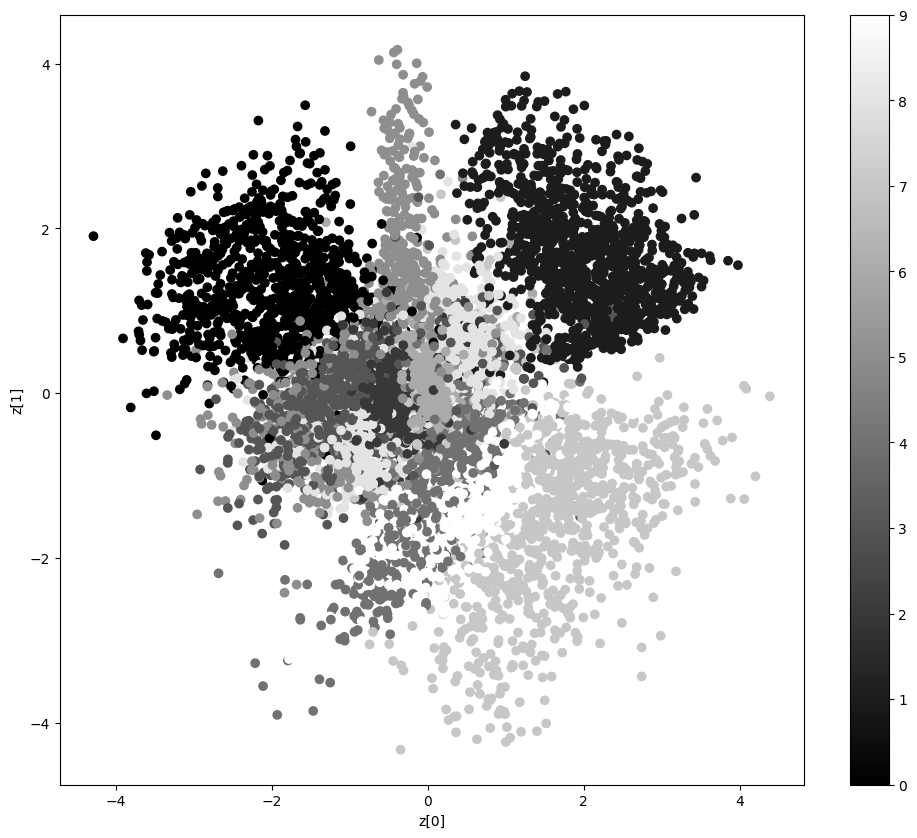

1/1 [==============================] - 0s 26ms/step


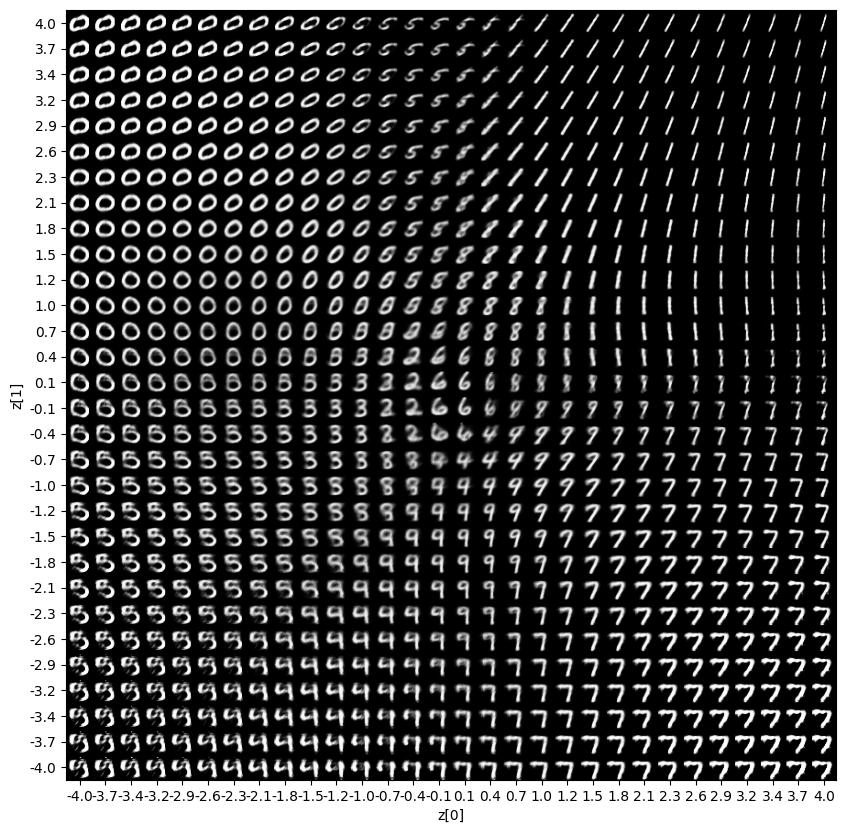

In [27]:
plot_results(encoder, decoder, x_test, y_test, batch_size=batch_size)

## Завдання на лабораторну роботу

Виконати приклади. Навести пояснення роботи відповідних нейронних мереж